# About this note
- pytorch
- Fine tune
- Image classification

## Library

In [1]:
import glob
import os.path as osp
import random
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import models,transforms
import torchvision
print('Pytorch ver:',torch.__version__)
print('torchvison ver:',torchvision.__version__)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:',device)

Pytorch ver: 1.7.1
torchvison ver: 0.8.2
device: cpu


In [2]:
# config
class CFG():
    size = 224
    seed = 2021
    pretrained = True

    batch_size = 32
    lr = 0.001

    epoch = 2


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(CFG.seed)

In [3]:
# preprocess
class ImgTransform():
    # preprocess

    def __init__(self):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(CFG.size, scale=(0.5,10)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225))
                ]),

            'val': transforms.Compose([
                transforms.Resize(CFG.size),
                transforms.CenterCrop(CFG.size),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225))
                ]),
                }
            

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [4]:
image_path = './goldenretriever-3724972_640.jpg'
img = Image.open(image_path)

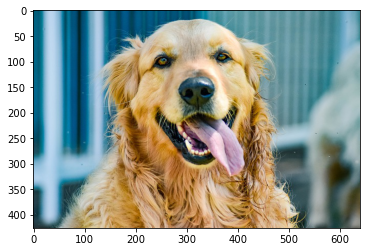

In [5]:
# 画像表示
plt.imshow(img);

In [6]:
transform = ImgTransform()
img_transformed = transform(img)
print(img_transformed.shape)
print(img_transformed.max())
print(img_transformed.min())

img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
print(img_transformed.shape)
print(img_transformed.max())
print(img_transformed.min())

torch.Size([3, 224, 224])
tensor(2.4483)
tensor(-2.1179)
(224, 224, 3)
1.0
0.0


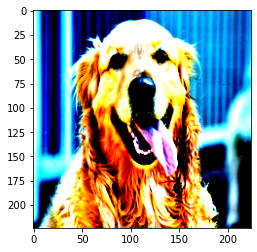

In [7]:
plt.imshow(img_transformed);

In [8]:
# get image_path
def make_datapath_list(phase='train'):

    root_path = './hymenoptera_data/'
    target_path = osp.join(root_path +phase +'/**/*.jpg')
    print(target_path)

    path_list = []

    # globでサブディレクトリまで取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

./hymenoptera_data/train/**/*.jpg
./hymenoptera_data/val/**/*.jpg


In [9]:
train_list[:10]

['./hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg',
 './hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg',
 './hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg',
 './hymenoptera_data/train/bees/2962405283_22718d9617.jpg',
 './hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg',
 './hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg',
 './hymenoptera_data/train/bees/2704348794_eb5d5178c2.jpg',
 './hymenoptera_data/train/bees/2358061370_9daabbd9ac.jpg',
 './hymenoptera_data/train/bees/2861002136_52c7c6f708.jpg',
 './hymenoptera_data/train/bees/266644509_d30bb16a1b.jpg']

In [10]:
# dataset
class ImgDataset(data.Dataset):

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img, self.phase)
        
        if self.phase == 'train':
            img_label = img_path[25:29]
        else:
            img_label = img_path[23:27]

        if img_label == 'ants':
            img_label = 0
        elif img_label == 'bees':
            img_label = 1

        return img_transformed,img_label

In [11]:
train_dataset = ImgDataset(file_list=train_list, transform=ImgTransform(),phase='train')
val_dataset = ImgDataset(file_list=val_list, transform=ImgTransform(),phase='val')

In [12]:
# Dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=CFG.batch_size,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False)

dataloader_dict = {'train':train_dataloader,'val':val_dataloader}
batch_iter = iter(dataloader_dict['train'])

inputs, labels = next(batch_iter)
print('input_size:',inputs.size())
print(labels)

input_size: torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0])


In [13]:
# vgg16
model = models.vgg16(pretrained=CFG.pretrained)
model.classifier[6] = nn.Linear(in_features=4096,out_features=2)

# 訓練モード
model.train()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# 損失関数
criterion = nn.CrossEntropyLoss()

In [15]:
# 転移学習
params_update1 = []
params_update2 = []
params_update3 = []

update_layer1 = 'features'
update_layer2 = ['classifier.0.weight', 'classifier.0.bias','classifier.3.weight', 'classifier.3.bias',]
update_layer3 = ['classifier.6.weight', 'classifier.6.bias']

for name, param in model.named_parameters():
    if update_layer1 in name:
        # 学習レイヤー
        param.requires_grad = True
        params_update1.append(param)
        print('update1:',name)
    
    elif name in update_layer2:
        param.requires_grad = True
        params_update2.append(param)
        print('update2:',name)
    
    elif name in update_layer3:
        param.requires_grad = True
        params_update3.append(param)
        print('update3:',name)

    else:
        # 凍結レイヤー
        param.requires_grad = False
        print('no update_layer:',name)

update1: features.0.weight
update1: features.0.bias
update1: features.2.weight
update1: features.2.bias
update1: features.5.weight
update1: features.5.bias
update1: features.7.weight
update1: features.7.bias
update1: features.10.weight
update1: features.10.bias
update1: features.12.weight
update1: features.12.bias
update1: features.14.weight
update1: features.14.bias
update1: features.17.weight
update1: features.17.bias
update1: features.19.weight
update1: features.19.bias
update1: features.21.weight
update1: features.21.bias
update1: features.24.weight
update1: features.24.bias
update1: features.26.weight
update1: features.26.bias
update1: features.28.weight
update1: features.28.bias
update2: classifier.0.weight
update2: classifier.0.bias
update2: classifier.3.weight
update2: classifier.3.bias
update3: classifier.6.weight
update3: classifier.6.bias


In [16]:
# 最適化
optimizer = optim.SGD([
    {'params': params_update1, 'lr':0.0001},
    {'params': params_update2, 'lr':0.0005},
    {'params': params_update3, 'lr':0.001},
    ], momentum=0.9)

In [17]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epochs):

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0
            epoch_corr = 0

            if epoch == 0 and phase == 'train':
                continue

            for inputs, labels in tqdm(dataloader_dict[phase]):
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item()*inputs.size(0)
                    epoch_corr += torch.sum(preds==labels.data)
            
            epoch_loss = epoch_loss/len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corr.double()/len(dataloader_dict[phase].dataset)

            print('{} Loss:{:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))

train_model(model, dataloader_dict, criterion, optimizer, CFG.epoch)

  0%|          | 0/8 [00:00<?, ?it/s]val Loss:0.7751 Acc:0.4575
Epoch 2/2
100%|██████████| 5/5 [01:45<00:00, 21.12s/it]val Loss:0.1742 Acc:0.9477

